# sLDSC analysis

In [3]:
library(data.table)
library(tidyverse)
library(RColorBrewer)
library(wesanderson)

In [8]:
setwd("~/project-gandalm/isoform_twas/sLDSC/")

### 1: SuSiE-maxCPP-sLDSC, e/iso/sQTL, run separately

In [9]:
eqtl <- read.table("results/PGC3_SCZ_wave3.european.autosome.public.v3_mixed_eqtl_maxCPP.results", header = T)
isoqtl <- read.table("results/PGC3_SCZ_wave3.european.autosome.public.v3_mixed_isoqtl_maxCPP.results", header = T)
sqtl <- read.table("results/PGC3_SCZ_wave3.european.autosome.public.v3_mixed_sqtl_maxCPP.results", header = T)

**Use the same stats for background annotations**

In [19]:
variance <- c()
for (i in c(1:53)) {
    variance <- append(variance, var(c(eqtl[i,'Enrichment'], isoqtl[i,'Enrichment'], sqtl[i,'Enrichment'])))
}

In [20]:
range(variance)

[1] 7.888609e-31 1.634779e-02

In [10]:
eqtl <- eqtl %>% 
    mutate(Enrichment_p_fdr = p.adjust(Enrichment_p, 'fdr')) %>%
    mutate(tau_pval  = pnorm(Coefficient_z.score, lower.tail = FALSE)) %>%
    mutate(tau_fdr  = p.adjust(tau_pval, method = 'fdr'))

eqtl <- eqtl[order(eqtl$Enrichment, decreasing = TRUE),]
subset_eqtl <- eqtl[c(1:15),]
subset_eqtl[subset_eqtl$Category=="L2_1",1] <- "eQTL"
subset_eqtl$Category <- gsub(".bedL2_0","",subset_eqtl$Category)

isoqtl <- isoqtl %>% 
    mutate(Enrichment_p_fdr = p.adjust(Enrichment_p, 'fdr')) %>%
    mutate(tau_pval  = pnorm(Coefficient_z.score, lower.tail = FALSE)) %>%
    mutate(tau_fdr  = p.adjust(tau_pval, method = 'fdr'))
isoqtl[isoqtl$Category=="L2_1",1] <- "isoQTL"
isoqtl <- isoqtl %>% filter(Category == "isoQTL")

sqtl <- sqtl %>% 
    mutate(Enrichment_p_fdr = p.adjust(Enrichment_p, 'fdr')) %>%
    mutate(tau_pval  = pnorm(Coefficient_z.score, lower.tail = FALSE)) %>%
    mutate(tau_fdr  = p.adjust(tau_pval, method = 'fdr'))
sqtl[sqtl$Category=="L2_1",1] <- "sQTL"
sqtl <- sqtl %>% filter(Category == "sQTL")

subset_dat <- rbind(subset_eqtl, isoqtl, sqtl)

In [11]:
subset_dat <- subset_dat %>% mutate(Category = paste0(Category, " (", 100*signif(Prop._SNPs, 2), "%)"))
# subset_dat

In [12]:
# Adding asterisk for p-val significance
subset_dat$asterisk_pos <- subset_dat$Enrichment + subset_dat$Enrichment_std_error + .35
signif_df_05 <- data.frame(Category = subset_dat[subset_dat$Enrichment_p_fdr<=.05 & subset_dat$Enrichment_p_fdr>.01,'Category'],
                        Enrichment = subset_dat[subset_dat$Enrichment_p_fdr<=.05 & subset_dat$Enrichment_p_fdr>.01, 'asterisk_pos'])
signif_df_01 <- data.frame(Category = subset_dat[subset_dat$Enrichment_p_fdr<=.01 & subset_dat$Enrichment_p_fdr>.001,'Category'],
                           Enrichment = subset_dat[subset_dat$Enrichment_p_fdr<=.01 & subset_dat$Enrichment_p_fdr>.001, 'asterisk_pos'])
signif_df_001 <- data.frame(Category = subset_dat[subset_dat$Enrichment_p_fdr<=.001,'Category'],
                           Enrichment = subset_dat[subset_dat$Enrichment_p_fdr<=.001, 'asterisk_pos'])

In [13]:
subset_dat$group <- "Baseline"
for(i in 1:nrow(subset_dat)) {
    if(subset_dat[i,'Category'] == "eQTL (0.1%)") {
        subset_dat[i,'group'] <- "eQTL"
    }
    if(subset_dat[i,'Category'] == "isoQTL (0.2%)") {
        subset_dat[i,'group'] <- "isoQTL"
    }
    if(subset_dat[i,'Category'] == "sQTL (0.15%)") {
        subset_dat[i,'group'] <- "sQTL"
    }
}

In [14]:
subset_dat <- subset_dat %>% arrange(desc(Enrichment))

In [15]:
subset_dat <- subset_dat %>% mutate(Category = factor(Category, levels = Category))

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


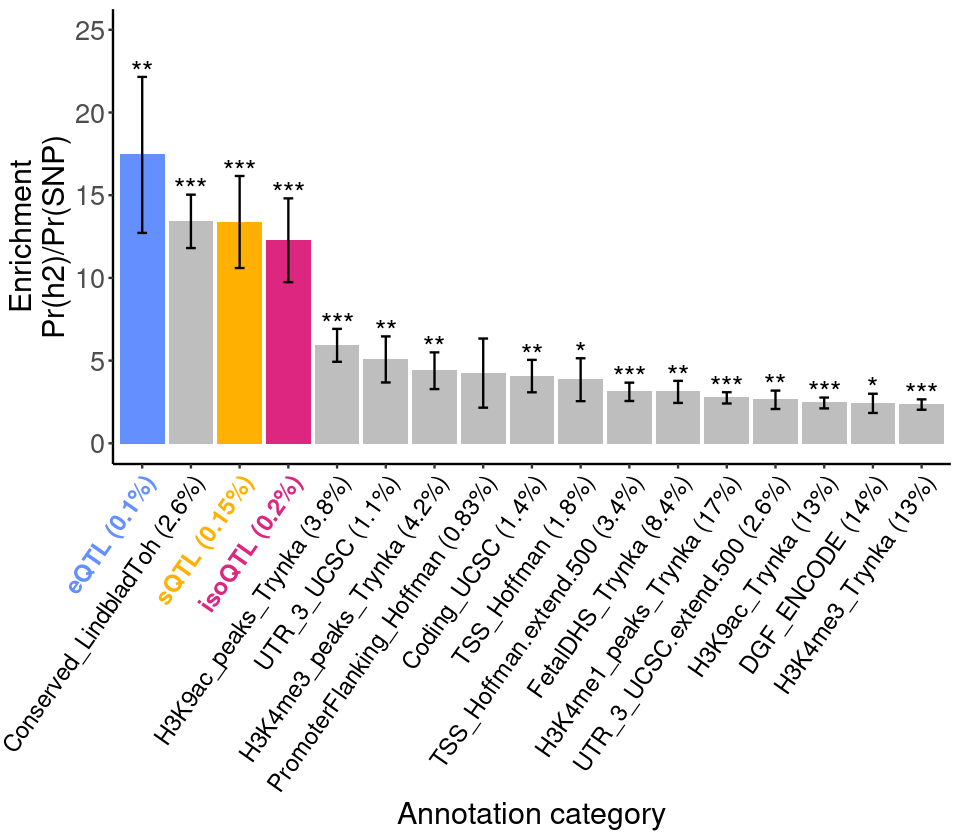

In [16]:
options(repr.plot.width = 8, repr.plot.height = 7)

ggplot(subset_dat, aes(x = Category, 
                       y = Enrichment)) +
  geom_bar(stat = "identity", width = .9, aes(fill = group)) +
  geom_errorbar(aes(ymin = (Enrichment-Enrichment_std_error), 
                    ymax = (Enrichment+Enrichment_std_error)), 
                width = .2) +
  scale_fill_manual(name = "Category", values = c("grey", "#648FFF", "#DC267F", "#FFB000")) +
#   ggtitle("Partitioned heritability SCZ GWAS", subtitle = "") +
  xlab("Annotation category") +
  ylab("Enrichment\nPr(h2)/Pr(SNP)") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 55, hjust = 1, size = 14, 
                                   color = ifelse(subset_dat$group == "eQTL", "#648FFF",
                                                  ifelse(subset_dat$group == "isoQTL", "#DC267F",
                                                        ifelse(subset_dat$group == "sQTL", "#FFB000", "black"))),
                                   face = ifelse(subset_dat$group == "eQTL", "bold",
                                                  ifelse(subset_dat$group == "isoQTL", "bold",
                                                        ifelse(subset_dat$group == "sQTL", "bold", "plain")))),
        axis.text.y = element_text(size=16),
        axis.title = element_text(size=18),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        legend.position = "none") +
  ylim(0,25) +
  geom_text(data = signif_df_05, label = "*", size = 6) +
  geom_text(data = signif_df_01, label = "**", size = 6) +
  geom_text(data = signif_df_001, label = "***", size = 6) 
#   scale_x_discrete(labels = display)

In [47]:
ggsave("figures/enrich.pdf", height = 7, width = 8)

In [48]:
eqtl <- read.table("results/PGC3_SCZ_wave3.european.autosome.public.v3_mixed_eqtl_maxCPP.results", header = T)
isoqtl <- read.table("results/PGC3_SCZ_wave3.european.autosome.public.v3_mixed_isoqtl_maxCPP.results", header = T)
sqtl <- read.table("results/PGC3_SCZ_wave3.european.autosome.public.v3_mixed_sqtl_maxCPP.results", header = T)

eqtl <- eqtl %>% 
#     mutate(Enrichment_p_fdr = p.adjust(Enrichment_p, 'fdr')) %>%
    mutate(tau_pval  = pnorm(Coefficient_z.score, lower.tail = FALSE)) %>%
    mutate(tau_fdr  = p.adjust(tau_pval, method = 'fdr'))

eqtl <- eqtl[order(eqtl$Coefficient_z.score, decreasing = TRUE),]
subset_eqtl <- eqtl[c(1:15),]
subset_eqtl[subset_eqtl$Category=="L2_1",1] <- "eQTL"
subset_eqtl$Category <- gsub(".bedL2_0","",subset_eqtl$Category)

isoqtl <- isoqtl %>% 
#     mutate(Enrichment_p_fdr = p.adjust(Enrichment_p, 'fdr')) %>%
    mutate(tau_pval  = pnorm(Coefficient_z.score, lower.tail = FALSE)) %>%
    mutate(tau_fdr  = p.adjust(tau_pval, method = 'fdr'))
isoqtl[isoqtl$Category=="L2_1",1] <- "isoQTL"
isoqtl <- isoqtl %>% filter(Category == "isoQTL")

sqtl <- sqtl %>% 
#     mutate(Enrichment_p_fdr = p.adjust(Enrichment_p, 'fdr')) %>%
    mutate(tau_pval  = pnorm(Coefficient_z.score, lower.tail = FALSE)) %>%
    mutate(tau_fdr  = p.adjust(tau_pval, method = 'fdr'))
sqtl[sqtl$Category=="L2_1",1] <- "sQTL"
sqtl <- sqtl %>% filter(Category == "sQTL")

subset_dat <- rbind(subset_eqtl, isoqtl, sqtl)

subset_dat <- subset_dat %>% mutate(Category = paste0(Category, " (", 100*signif(Prop._SNPs, 2), "%)"))


subset_dat$group <- "Baseline"
for(i in 1:nrow(subset_dat)) {
    if(subset_dat[i,'Category'] == "eQTL (0.1%)") {
        subset_dat[i,'group'] <- "eQTL"
    }
    if(subset_dat[i,'Category'] == "isoQTL (0.2%)") {
        subset_dat[i,'group'] <- "isoQTL"
    }
    if(subset_dat[i,'Category'] == "sQTL (0.15%)") {
        subset_dat[i,'group'] <- "sQTL"
    }
}

subset_dat <- subset_dat %>% arrange(desc(Coefficient_z.score))
subset_dat <- subset_dat %>% mutate(Category = factor(Category, levels = Category))

In [50]:
subset_dat$asterisk_pos <- subset_dat$Coefficient_z.score + .35
signif_df_05 <- data.frame(Category = subset_dat[subset_dat$tau_fdr<=.05 & subset_dat$tau_fdr>.01,'Category'],
                        Coefficient_z.score = subset_dat[subset_dat$tau_fdr<=.05 & subset_dat$tau_fdr>.01, 'asterisk_pos'])
signif_df_01 <- data.frame(Category = subset_dat[subset_dat$tau_fdr<=.01 & subset_dat$tau_fdr>.001,'Category'],
                           Coefficient_z.score = subset_dat[subset_dat$tau_fdr<=.01 & subset_dat$tau_fdr>.001, 'asterisk_pos'])
signif_df_001 <- data.frame(Category = subset_dat[subset_dat$tau_fdr<=.001,'Category'],
                           Coefficient_z.score = subset_dat[subset_dat$tau_fdr<=.001, 'asterisk_pos'])

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


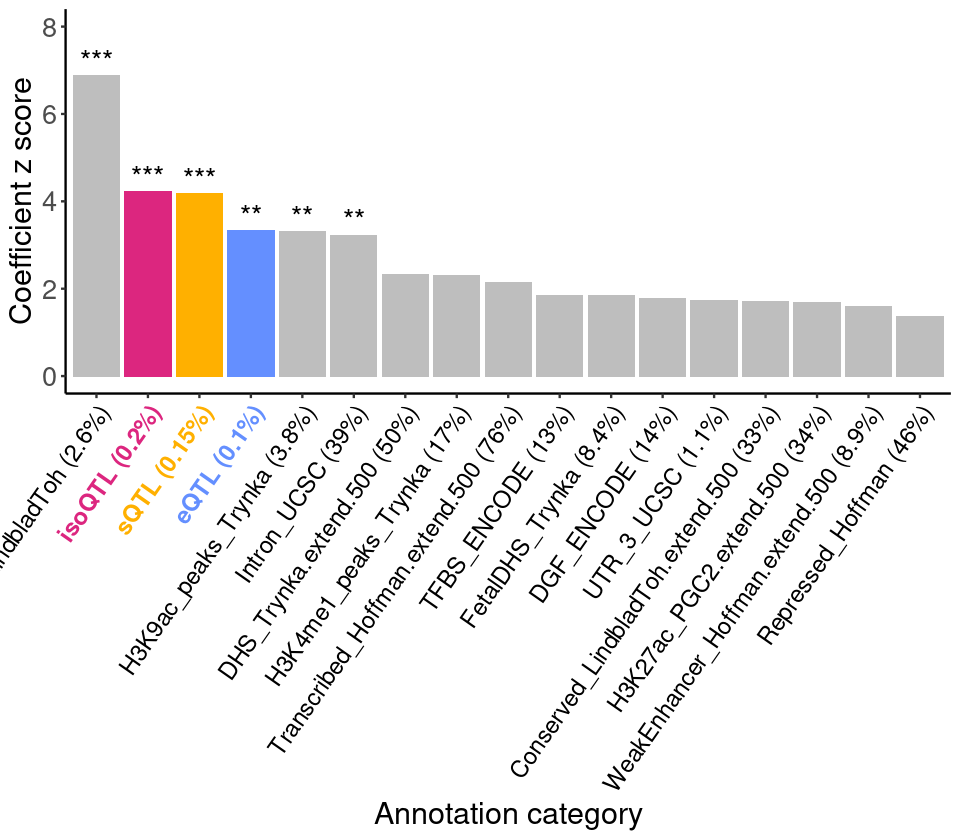

In [51]:
options(repr.plot.width = 8, repr.plot.height = 7)

ggplot(subset_dat, aes(x = Category, 
                       y = Coefficient_z.score)) +
  geom_bar(stat = "identity", width = .9, aes(fill = group)) +
  scale_fill_manual(name = "Category", values = c("grey", "#648FFF", "#DC267F", "#FFB000")) +
  xlab("Annotation category") +
  ylab("Coefficient z score") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 55, hjust = 1, size = 14, 
                                   color = ifelse(subset_dat$group == "eQTL", "#648FFF",
                                                  ifelse(subset_dat$group == "isoQTL", "#DC267F",
                                                        ifelse(subset_dat$group == "sQTL", "#FFB000", "black"))),
                                   face = ifelse(subset_dat$group == "eQTL", "bold",
                                                  ifelse(subset_dat$group == "isoQTL", "bold",
                                                        ifelse(subset_dat$group == "sQTL", "bold", "plain")))),
        axis.text.y = element_text(size=16),
        axis.title = element_text(size=18),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        legend.position = "none") +
  ylim(0,8) +
  geom_text(data = signif_df_05, label = "*", size = 6) +
  geom_text(data = signif_df_01, label = "**", size = 6) +
  geom_text(data = signif_df_001, label = "***", size = 6)

In [53]:
ggsave("figures/tau_zscore.pdf", height = 7, width = 8)

### 2: e-iso run together; e-iso-s run together

In [76]:
dat <- read.table("results/PGC3_SCZ_wave3.european.autosome.public.v3_mixed_e_iso_sqtl_maxCPP.results", header = T)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


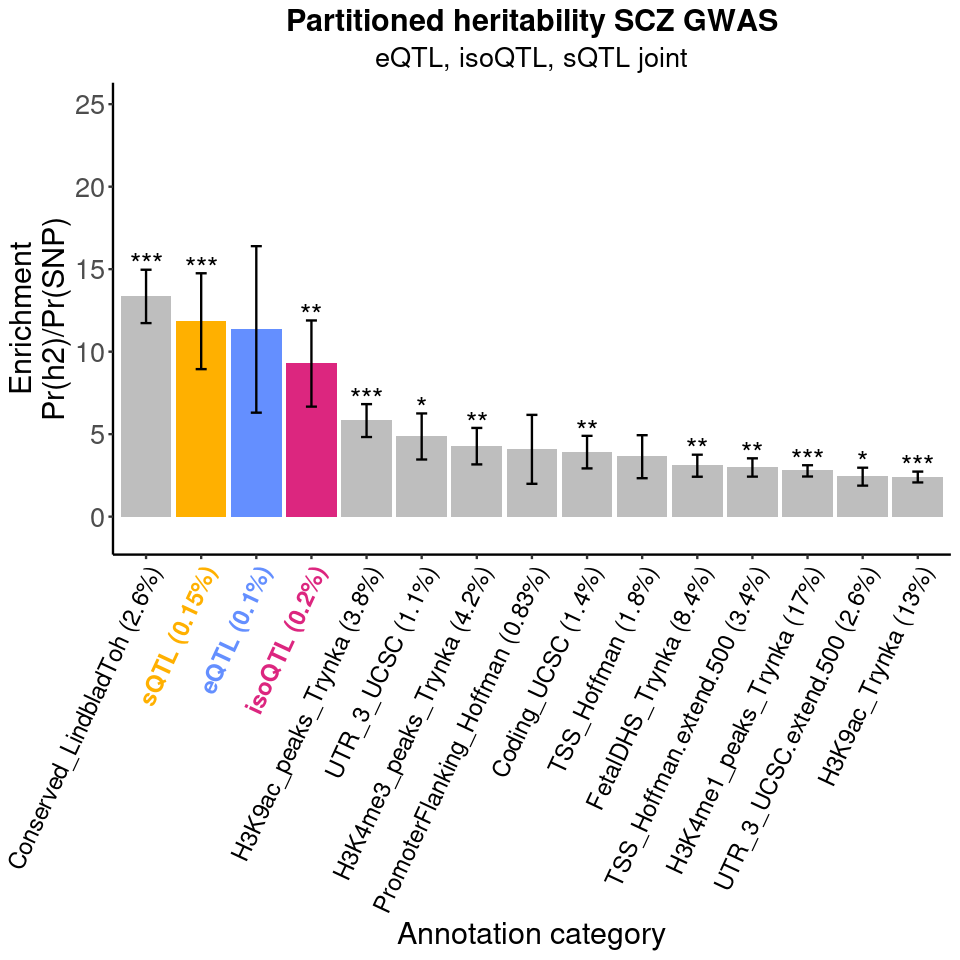

In [77]:
dat$Enrichment_p_fdr <- p.adjust(dat$Enrichment_p, "fdr")
dat <- dat[order(dat$Enrichment, decreasing=TRUE),]
subset_dat <- dat[c(1:15),]
subset_dat[subset_dat$Category=="L2_1",1] <- "eQTL"
subset_dat[subset_dat$Category=="L2_2",1] <- "isoQTL"
subset_dat[subset_dat$Category=="L2_3",1] <- "sQTL"
subset_dat$Category <- gsub(".bedL2_0","",subset_dat$Category)

subset_dat <- subset_dat %>% mutate(Category = paste0(Category, " (", 100*signif(Prop._SNPs, 2), "%)"))


# Adding asterisk for p-val significance
subset_dat$asterisk_pos <- subset_dat$Enrichment + subset_dat$Enrichment_std_error + .35
signif_df_05 <- data.frame(Category = subset_dat[subset_dat$Enrichment_p_fdr<=.05 & 
                                                 subset_dat$Enrichment_p_fdr>.01,'Category'],
                           Enrichment = subset_dat[subset_dat$Enrichment_p_fdr<=.05 & 
                                                   subset_dat$Enrichment_p_fdr>.01, 'asterisk_pos'])
signif_df_01 <- data.frame(Category = subset_dat[subset_dat$Enrichment_p_fdr<=.01 & 
                                                 subset_dat$Enrichment_p_fdr>.001,'Category'],
                           Enrichment = subset_dat[subset_dat$Enrichment_p_fdr<=.01 & 
                                                   subset_dat$Enrichment_p_fdr>.001, 'asterisk_pos'])
signif_df_001 <- data.frame(Category = subset_dat[subset_dat$Enrichment_p_fdr<=.001,'Category'],
                            Enrichment = subset_dat[subset_dat$Enrichment_p_fdr<=.001, 'asterisk_pos'])

subset_dat$group <- "Baseline"
for(i in 1:nrow(subset_dat)) {
    if(subset_dat[i,'Category'] == "eQTL (0.1%)") {
        subset_dat[i,'group'] <- "eQTL"
    }
    if(subset_dat[i,'Category'] == "isoQTL (0.2%)") {
        subset_dat[i,'group'] <- "isoQTL"
    }
    if(subset_dat[i,'Category'] == "sQTL (0.15%)") {
        subset_dat[i,'group'] <- "sQTL"
    }
}

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(subset_dat, aes(x = reorder(Category, -Enrichment), 
                       y = Enrichment)) +
  geom_bar(stat = "identity", width = .9, aes(fill = group)) +
  geom_errorbar(aes(ymin = (Enrichment-Enrichment_std_error), 
                    ymax = (Enrichment+Enrichment_std_error)), 
                width = .2) +
  scale_fill_manual(name = "Category", values = c("grey", "#648FFF", "#DC267F", "#FFB000")) +
  ggtitle("Partitioned heritability SCZ GWAS", subtitle = "eQTL, isoQTL, sQTL joint") +
  xlab("Annotation category") +
  ylab("Enrichment\nPr(h2)/Pr(SNP)") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 65, hjust = 1, size = 14, 
                                   color = ifelse(subset_dat$group == "eQTL", "#648FFF",
                                                  ifelse(subset_dat$group == "sQTL", "#FFB000",
                                                        ifelse(subset_dat$group == "isoQTL", "#DC267F", "black"))),
                                   face = ifelse(subset_dat$group %in% c("eQTL", "isoQTL", "sQTL"), "bold", "plain")),
        axis.text.y = element_text(size=16),
        axis.title = element_text(size=18),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=16, hjust = 0.5),
        legend.position = "none") +
  ylim(-1,25) +
  geom_text(data = signif_df_05, label = "*", size = 6) +
  geom_text(data = signif_df_01, label = "**", size = 6) +
  geom_text(data = signif_df_001, label = "***", size = 6) 
#   scale_x_discrete(labels = display)

In [78]:
ggsave("figures/enrich_e_iso_s.pdf", height = 8, width = 8)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


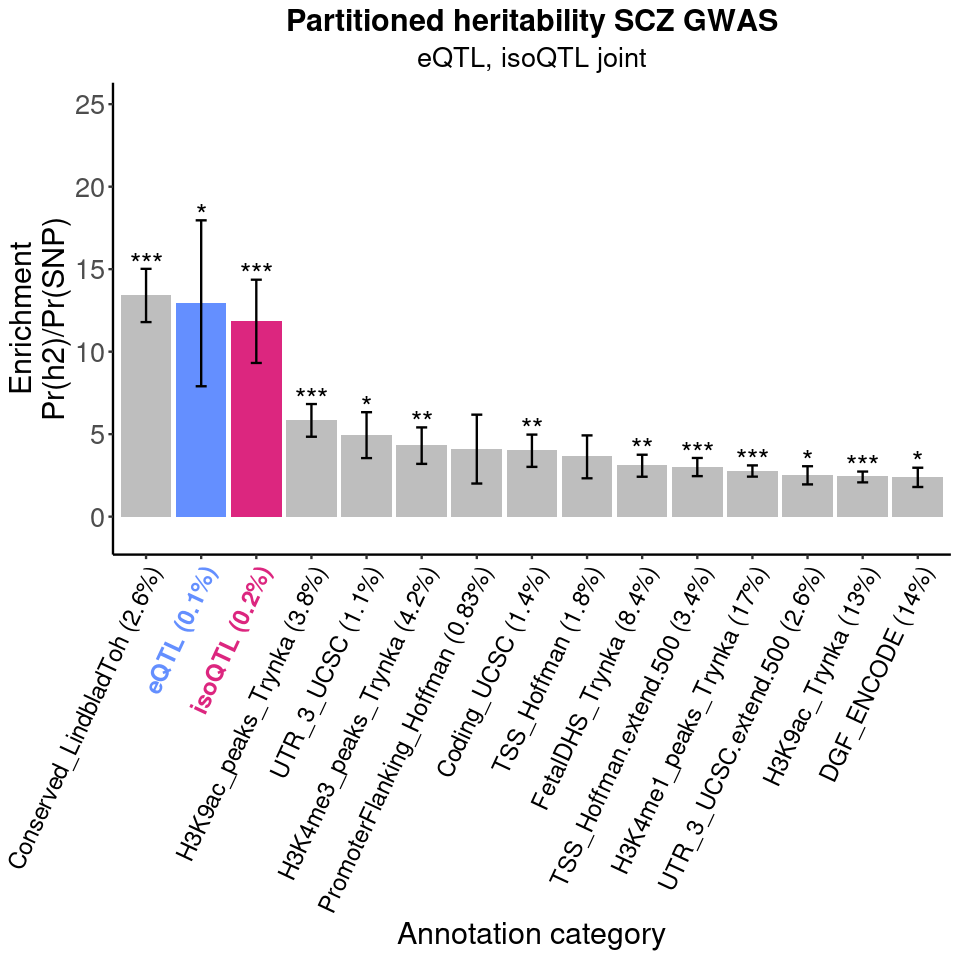

In [74]:
dat <- read.table("results/PGC3_SCZ_wave3.european.autosome.public.v3_mixed_e_isoqtl_maxCPP.results", header = T)

dat$Enrichment_p_fdr <- p.adjust(dat$Enrichment_p, "fdr")
dat <- dat[order(dat$Enrichment, decreasing=TRUE),]
subset_dat <- dat[c(1:15),]
subset_dat[subset_dat$Category=="L2_1",1] <- "eQTL"
subset_dat[subset_dat$Category=="L2_2",1] <- "isoQTL"
subset_dat$Category <- gsub(".bedL2_0","",subset_dat$Category)

subset_dat <- subset_dat %>% mutate(Category = paste0(Category, " (", 100*signif(Prop._SNPs, 2), "%)"))


# Adding asterisk for p-val significance
subset_dat$asterisk_pos <- subset_dat$Enrichment + subset_dat$Enrichment_std_error + .35
signif_df_05 <- data.frame(Category = subset_dat[subset_dat$Enrichment_p_fdr<=.05 & 
                                                 subset_dat$Enrichment_p_fdr>.01,'Category'],
                           Enrichment = subset_dat[subset_dat$Enrichment_p_fdr<=.05 & 
                                                   subset_dat$Enrichment_p_fdr>.01, 'asterisk_pos'])
signif_df_01 <- data.frame(Category = subset_dat[subset_dat$Enrichment_p_fdr<=.01 & 
                                                 subset_dat$Enrichment_p_fdr>.001,'Category'],
                           Enrichment = subset_dat[subset_dat$Enrichment_p_fdr<=.01 & 
                                                   subset_dat$Enrichment_p_fdr>.001, 'asterisk_pos'])
signif_df_001 <- data.frame(Category = subset_dat[subset_dat$Enrichment_p_fdr<=.001,'Category'],
                            Enrichment = subset_dat[subset_dat$Enrichment_p_fdr<=.001, 'asterisk_pos'])

subset_dat$group <- "Baseline"
for(i in 1:nrow(subset_dat)) {
    if(subset_dat[i,'Category'] == "eQTL (0.1%)") {
        subset_dat[i,'group'] <- "eQTL"
    }
    if(subset_dat[i,'Category'] == "isoQTL (0.2%)") {
        subset_dat[i,'group'] <- "isoQTL"
    }
}

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(subset_dat, aes(x = reorder(Category, -Enrichment), 
                       y = Enrichment)) +
  geom_bar(stat = "identity", width = .9, aes(fill = group)) +
  geom_errorbar(aes(ymin = (Enrichment-Enrichment_std_error), 
                    ymax = (Enrichment+Enrichment_std_error)), 
                width = .2) +
  scale_fill_manual(name = "Category", values = c("grey", "#648FFF", "#DC267F")) +
  ggtitle("Partitioned heritability SCZ GWAS", subtitle = "eQTL, isoQTL joint") +
  xlab("Annotation category") +
  ylab("Enrichment\nPr(h2)/Pr(SNP)") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 65, hjust = 1, size = 14, 
                                   color = ifelse(subset_dat$group == "eQTL", "#648FFF",
                                                        ifelse(subset_dat$group == "isoQTL", "#DC267F", "black")),
                                   face = ifelse(subset_dat$group %in% c("eQTL", "isoQTL"), "bold", "plain")),
        axis.text.y = element_text(size=16),
        axis.title = element_text(size=18),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=16, hjust = 0.5),
        legend.position = "none") +
  ylim(-1,25) +
  geom_text(data = signif_df_05, label = "*", size = 6) +
  geom_text(data = signif_df_01, label = "**", size = 6) +
  geom_text(data = signif_df_001, label = "***", size = 6) 
#   scale_x_discrete(labels = display)

In [75]:
ggsave("figures/enrich_e_iso.pdf", height = 8, width = 8)

### 3. Enrichment tile plot

In [17]:
setwd("results/")

In [18]:
# setwd./ADHD.Demontis.2019_Brain_Cortex_Analysis_MaxCPP.cov./results/")
iso.results <- list.files(pattern = "*_mixed_isoqtl_maxCPP.results")

In [19]:
iso.results

[1] "ADHD.Demontis.2019_mixed_isoqtl_maxCPP.results"                        
[2] "ALZ.Jansen.2019_mixed_isoqtl_maxCPP.results"                           
[3] "ASD.iPSYCHPGC.2018_mixed_isoqtl_maxCPP.results"                        
[4] "EduYears.SSGAC.Lee2018_mixed_isoqtl_maxCPP.results"                    
[5] "Insomnia.Jansen.2018_mixed_isoqtl_maxCPP.results"                      
[6] "Intelligence.SavageNatGen.2018_mixed_isoqtl_maxCPP.results"            
[7] "MDD.Howard.PGC.2019_mixed_isoqtl_maxCPP.results"                       
[8] "pgc-bip2021-all_mixed_isoqtl_maxCPP.results"                           
[9] "PGC3_SCZ_wave3.european.autosome.public.v3_mixed_isoqtl_maxCPP.results"

In [20]:
e.results <- list.files(pattern = "*_mixed_eqtl_maxCPP.results")

In [21]:
s.results <- list.files(pattern = "*_mixed_sqtl_maxCPP.results")

In [22]:
gtex.results <- list.files(pattern = "*_Brain_Cortex_Analysis_MaxCPP.results")

In [23]:
end.res <- list.files(pattern = "*_end_100hcp_maxCPP.results")
ex.res <- list.files(pattern = "*_ex_90hcp_maxCPP.results")
in.res <- list.files(pattern = "*_in_90hcp_maxCPP.results")
ip.res <- list.files(pattern = "*_ip_80hcp_maxCPP.results")
mic.res <- list.files(pattern = "*_mic_80hcp_maxCPP.results")
opc.res <- list.files(pattern = "*_opc_80hcp_maxCPP.results")
per.res <- list.files(pattern = "*_per_70hcp_maxCPP.results")
pg.res <- list.files(pattern = "*_pg_80hcp_maxCPP.results")
rg.res <- list.files(pattern = "*_rg_100hcp_maxCPP.results")

In [24]:
tri1.e.res <- list.files(pattern = "*_tri1_25hcp_eqtl_maxCPP.result")
tri2.e.res <- list.files(pattern = "*_tri2_15hcp_eqtl_maxCPP.result")

tri1.s.res <- list.files(pattern = "*_tri1_15hcp_sqtl_maxCPP.result")
tri2.s.res <- list.files(pattern = "*_tri2_10hcp_sqtl_maxCPP.result")

male.e.res <- list.files(pattern = "*_m_50hcp_eqtl_maxCPP.result")
female.e.res <- list.files(pattern = "*_f_50hcp_eqtl_maxCPP.result")

In [25]:
for (i in 1:length(iso.results)) {
    file_name <- sub('_mixed_isoqtl_maxCPP.results', '', iso.results[i])
    file_df <- read.table(iso.results[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
}

iso.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
iso.df <- iso.df %>% filter(Category == "L2_1")
iso.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
iso.df$Group <- "isoQTL (0.2%)"

In [26]:
for (i in 1:length(e.results)) {
    file_name <- sub('_mixed_eqtl_maxCPP.results', '', e.results[i])
    file_df <- read.table(e.results[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
}

e.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
e.df <- e.df %>% filter(Category == "L2_1")
e.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
e.df$Group <- "eQTL (0.1%)"

In [27]:
for (i in 1:length(s.results)) {
    file_name <- sub('_mixed_sqtl_maxCPP.results', '', s.results[i])
    file_df <- read.table(s.results[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
}

s.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
s.df <- s.df %>% filter(Category == "L2_1")
s.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
s.df$Group <- "sQTL (0.15%)"

In [28]:
for (i in 1:length(gtex.results)) {
    file_name <- sub('_Brain_Cortex_Analysis_MaxCPP.results', '', gtex.results[i])
    file_df <- read.table(gtex.results[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
}

gtex.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
gtex.df <- gtex.df %>% filter(Category == "L2_1")
gtex.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
gtex.df$Group <- "GTEx Brain Cortex eQTL (0.05%)"

In [29]:
for (i in 1:length(end.res)) {
    file_name <- sub('_end_100hcp_maxCPP.results', '', end.res[i])
    file_df <- read.table(end.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

end.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
end.df <- end.df %>% filter(Category == "L2_1")
end.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
end.df$Group <- "end (0.06%)"

In [30]:
for (i in 1:length(ex.res)) {
    file_name <- sub('_ex_90hcp_maxCPP.results', '', ex.res[i])
    file_df <- read.table(ex.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

ex.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
ex.df <- ex.df %>% filter(Category == "L2_1")
ex.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
ex.df$Group <- "ex (0.07%)"

In [31]:
for (i in 1:length(in.res)) {
    file_name <- sub('_in_90hcp_maxCPP.results', '', in.res[i])
    file_df <- read.table(in.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

in.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
in.df <- in.df %>% filter(Category == "L2_1")
in.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
in.df$Group <- "in (0.06%)"

In [32]:
for (i in 1:length(ip.res)) {
    file_name <- sub('_ip_80hcp_maxCPP.results', '', ip.res[i])
    file_df <- read.table(ip.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

ip.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
ip.df <- ip.df %>% filter(Category == "L2_1")
ip.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
ip.df$Group <- "ip (0.06%)"

In [33]:
for (i in 1:length(mic.res)) {
    file_name <- sub('_mic_80hcp_maxCPP.results', '', mic.res[i])
    file_df <- read.table(mic.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

mic.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
mic.df <- mic.df %>% filter(Category == "L2_1")
mic.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
mic.df$Group <- "mic (0.04%)"

In [34]:
for (i in 1:length(opc.res)) {
    file_name <- sub('_opc_80hcp_maxCPP.results', '', opc.res[i])
    file_df <- read.table(opc.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

opc.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
opc.df <- opc.df %>% filter(Category == "L2_1")
opc.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
opc.df$Group <- "opc (0.04%)"

In [35]:
for (i in 1:length(per.res)) {
    file_name <- sub('_per_70hcp_maxCPP.results', '', per.res[i])
    file_df <- read.table(per.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

per.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
per.df <- per.df %>% filter(Category == "L2_1")
per.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
per.df$Group <- "per (0.03%)"

In [36]:
for (i in 1:length(pg.res)) {
    file_name <- sub('_pg_80hcp_maxCPP.results', '', pg.res[i])
    file_df <- read.table(pg.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

pg.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
pg.df <- pg.df %>% filter(Category == "L2_1")
pg.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
pg.df$Group <- "pg (0.06%)"

In [37]:
for (i in 1:length(rg.res)) {
    file_name <- sub('_rg_100hcp_maxCPP.results', '', rg.res[i])
    file_df <- read.table(rg.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

rg.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
rg.df <- rg.df %>% filter(Category == "L2_1")
rg.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
rg.df$Group <- "rg (0.07%)"

In [38]:
for (i in 1:length(tri1.e.res)) {
    file_name <- sub('_tri1_25hcp_eqtl_maxCPP.results', '', tri1.e.res[i])
    file_df <- read.table(tri1.e.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

tri1.e.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
tri1.e.df <- tri1.e.df %>% filter(Category == "L2_1")
tri1.e.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
tri1.e.df$Group <- "Trimester 1 eQTL (0.04%)"

In [39]:
for (i in 1:length(tri2.e.res)) {
    file_name <- sub('_tri2_15hcp_eqtl_maxCPP.results', '', tri2.e.res[i])
    file_df <- read.table(tri2.e.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

tri2.e.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
tri2.e.df <- tri2.e.df %>% filter(Category == "L2_1")
tri2.e.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
tri2.e.df$Group <- "Trimester 2 eQTL (0.02%)"

In [40]:
for (i in 1:length(tri1.s.res)) {
    file_name <- sub('_tri1_15hcp_sqtl_maxCPP.results', '', tri1.s.res[i])
    file_df <- read.table(tri1.s.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

tri1.s.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
tri1.s.df <- tri1.s.df %>% filter(Category == "L2_1")
tri1.s.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
tri1.s.df$Group <- "Trimester 1 sQTL (0.08%)"

In [41]:
for (i in 1:length(tri2.s.res)) {
    file_name <- sub('_tri2_10hcp_sqtl_maxCPP.results', '', tri2.s.res[i])
    file_df <- read.table(tri2.s.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

tri2.s.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
tri2.s.df <- tri2.s.df %>% filter(Category == "L2_1")
tri2.s.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
tri2.s.df$Group <- "Trimester 2 sQTL (0.03%)"

In [42]:
for (i in 1:length(female.e.res)) {
    file_name <- sub('_f_50hcp_eqtl_maxCPP.results', '', female.e.res[i])
    file_df <- read.table(female.e.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

female.e.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
female.e.df <- female.e.df %>% filter(Category == "L2_1")
female.e.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
female.e.df$Group <- "Female eQTL (0.05%)"

In [43]:
for (i in 1:length(male.e.res)) {
    file_name <- sub('_m_50hcp_eqtl_maxCPP.results', '', male.e.res[i])
    file_df <- read.table(male.e.res[i], header = T, stringsAsFactors = F)
    assign(x = file_name, value = file_df, envir = .GlobalEnv)
    }

male.e.df <- rbind(ADHD.Demontis.2019, ALZ.Jansen.2019, ASD.iPSYCHPGC.2018, 
                EduYears.SSGAC.Lee2018, 
                Insomnia.Jansen.2018, Intelligence.SavageNatGen.2018, MDD.Howard.PGC.2019, `pgc-bip2021-all`,
                PGC3_SCZ_wave3.european.autosome.public.v3)
male.e.df <- male.e.df %>% filter(Category == "L2_1")
male.e.df$Trait <- c("ADHD.Demontis.2019", "ALZ.Jansen.2019", "ASD.iPSYCHPGC.2018", 
                  "EduYears.SSGAC.Lee2018", 
                  "Insomnia.Jansen.2018", "Intelligence.SavageNatGen.2018", "MDD.Howard.PGC.2019", "pgc-bip2021-all", 
                  "PGC3_SCZ_wave3.european.autosome.public.v3")
male.e.df$Group <- "Male eQTL (0.06%)"

In [44]:
df <- rbind(e.df, iso.df, s.df, gtex.df, 
            end.df, ex.df, in.df, ip.df, mic.df, opc.df, per.df, pg.df, rg.df, 
            tri1.e.df, tri2.e.df, tri1.s.df, tri2.s.df, female.e.df, male.e.df)
df$Group <- factor(df$Group, levels = c("eQTL (0.1%)", "isoQTL (0.2%)", "sQTL (0.15%)",
                                        "GTEx Brain Cortex eQTL (0.05%)", 
                                        "end (0.06%)", "ex (0.07%)", "in (0.06%)", "ip (0.06%)",
                                        "mic (0.04%)", "opc (0.04%)", "per (0.03%)", "pg (0.06%)", "rg (0.07%)",
                                        "Trimester 1 eQTL (0.04%)", "Trimester 2 eQTL (0.02%)",
                                        "Trimester 1 sQTL (0.08%)", "Trimester 2 sQTL (0.03%)",
                                        "Female eQTL (0.05%)", "Male eQTL (0.06%)"))

In [45]:
df <- df %>% 
    mutate(tau_pval = pnorm(Coefficient_z.score, lower.tail = FALSE)) %>% #???
    mutate(tau_fdr = p.adjust(tau_pval, method = 'fdr')) %>% 
    mutate(enrich_fdr = p.adjust(Enrichment_p, method = 'fdr'))
#     mutate(tau.signif = ifelse(0.01 < tau_fdr < 0.05, "*", "")) %>%
#     mutate(en.signif = ifelse(enrich_fdr < 0.05, "*", ""))
df$tau.signif <- df$en.signif <- ' '
for (i in 1:nrow(df)) {
    if (df[i,'tau_fdr'] < 0.05 & df[i,'tau_fdr'] > 0.01) {
        df[i,'tau.signif'] <- "*"
    }
    if (df[i,'tau_fdr'] < 0.01 & df[i,'tau_fdr'] > 0.001) {
        df[i,'tau.signif'] <- "**"
    }
    if (df[i,'tau_fdr'] < 0.001) {
        df[i,'tau.signif'] <- "***"
    }
    if (df[i,'enrich_fdr'] < 0.05 & df[i,'enrich_fdr'] > 0.01) {
        df[i,'en.signif'] <- "*"
    }
    if (df[i,'enrich_fdr'] < 0.01 & df[i,'enrich_fdr'] > 0.001) {
        df[i,'en.signif'] <- "**"
    }
    if (df[i,'enrich_fdr'] < 0.001) {
        df[i,'en.signif'] <- "***"
    }
}

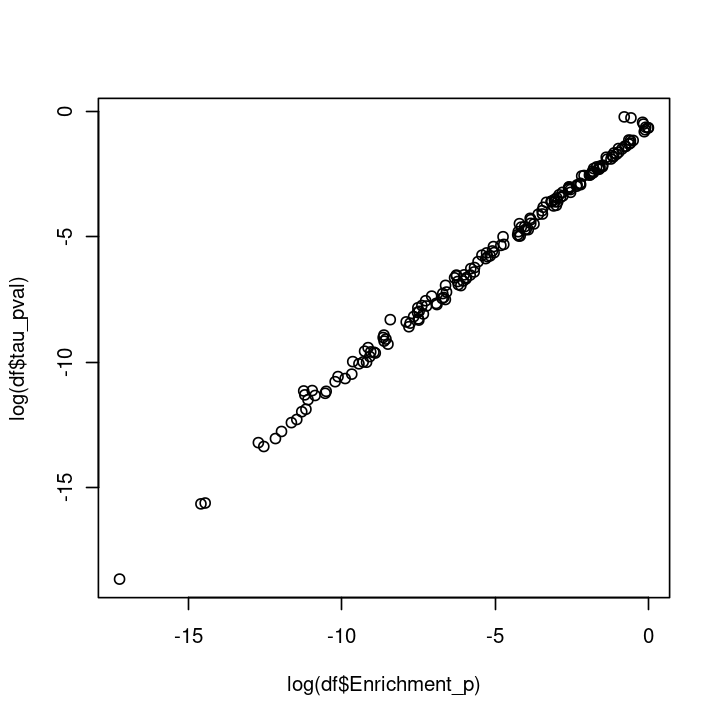

In [47]:
options(repr.plot.width = 6, repr.plot.height = 6)
plot(log(df$Enrichment_p), log(df$tau_pval))

In [30]:
# df <- df %>%
#     mutate(set = ifelse(Group %in% c("eQTL (0.1%)", "isoQTL (0.2%)", "sQTL (0.15%)"), 
#                         "Fetal QTL", "Cell type-specific eQTL")) 
# df[df$Group == "GTEx Brain Cortex eQTL (0.05%)", "set"] <- "GTEx eQTL"
# df

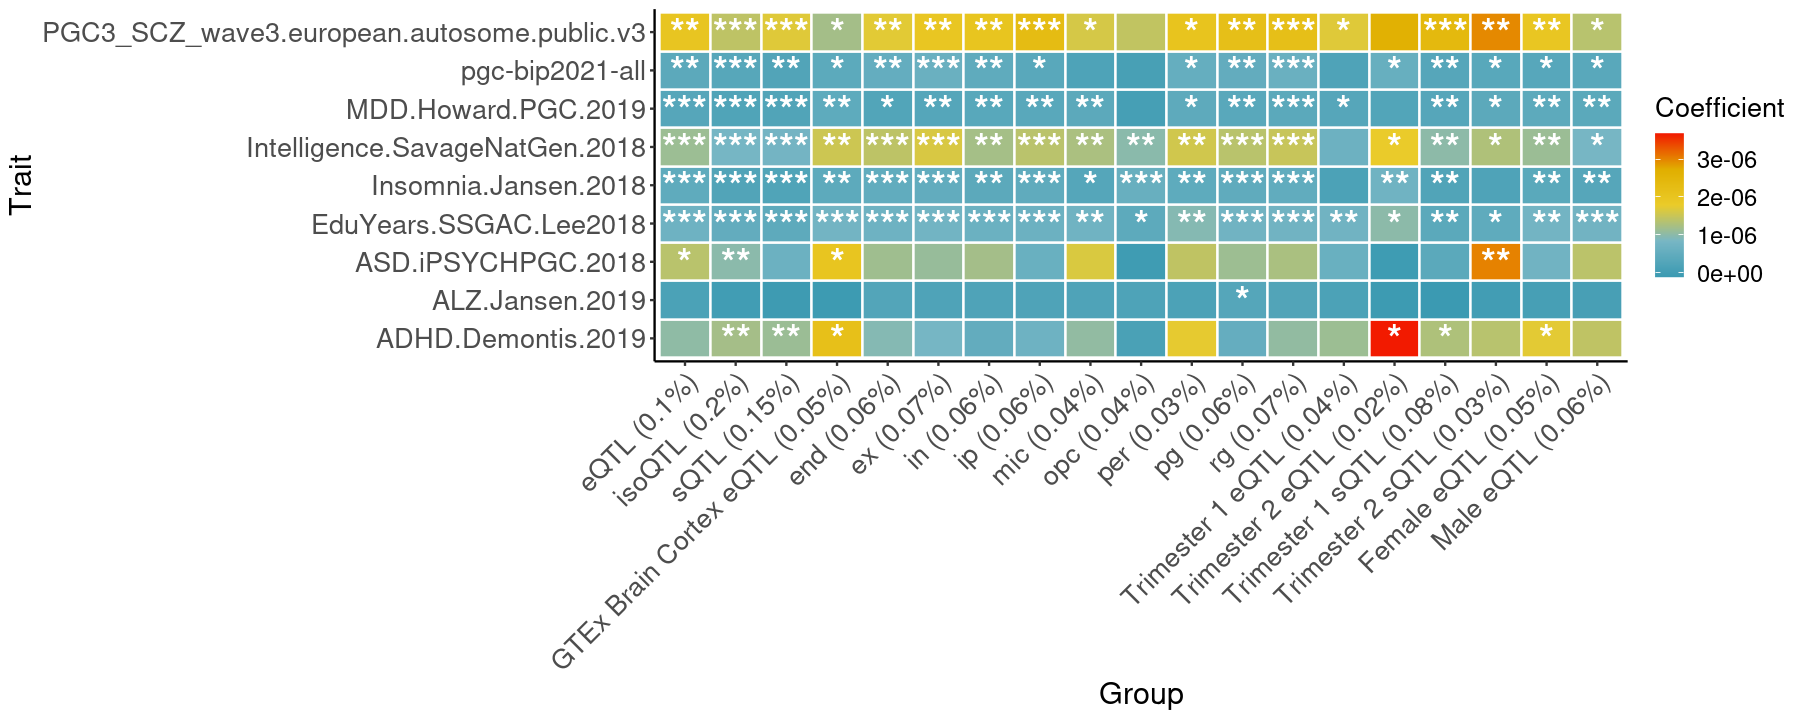

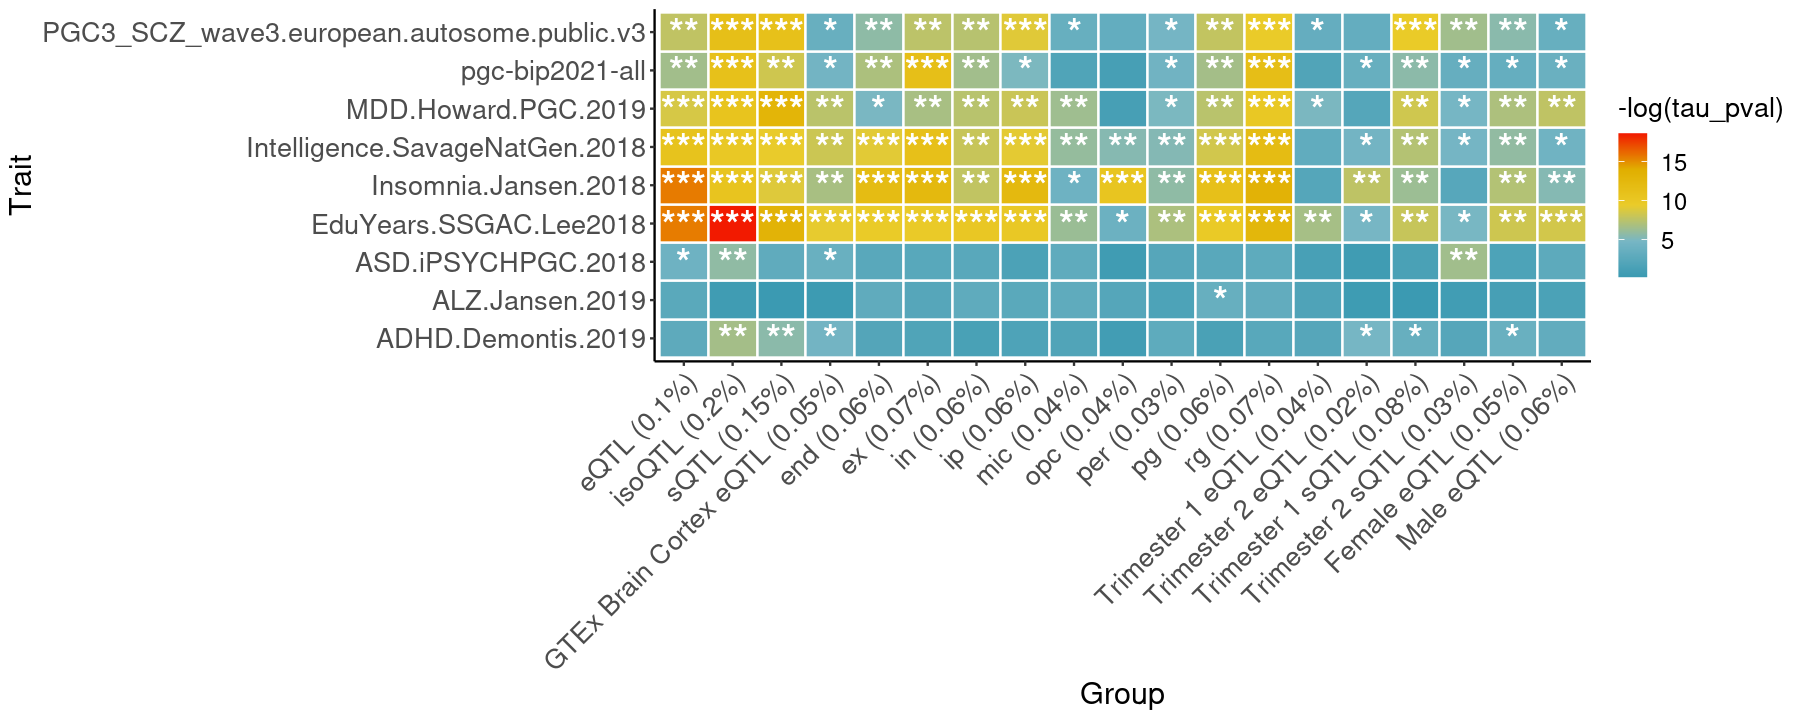

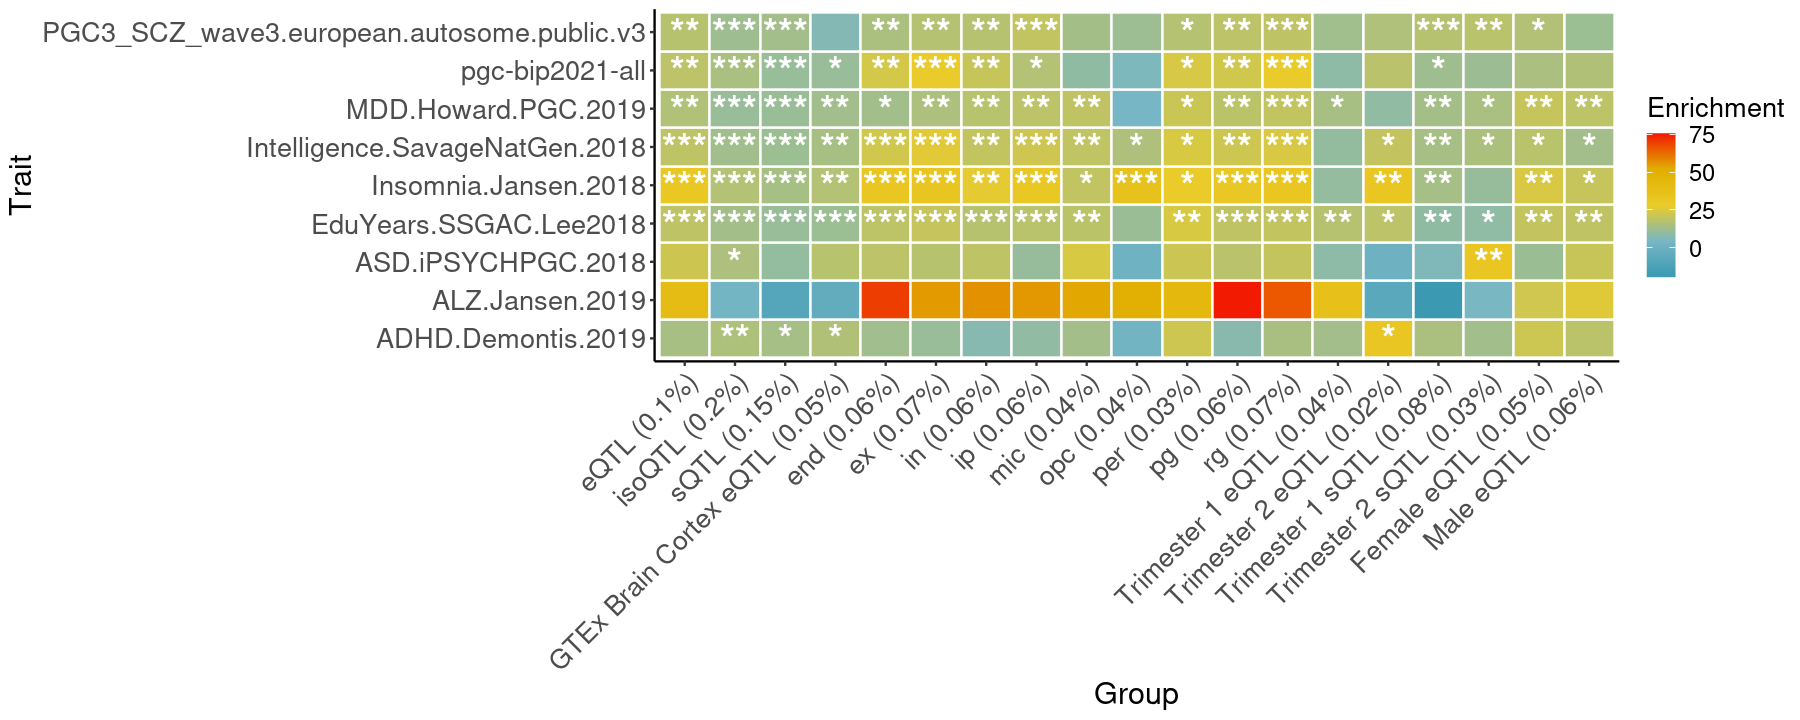

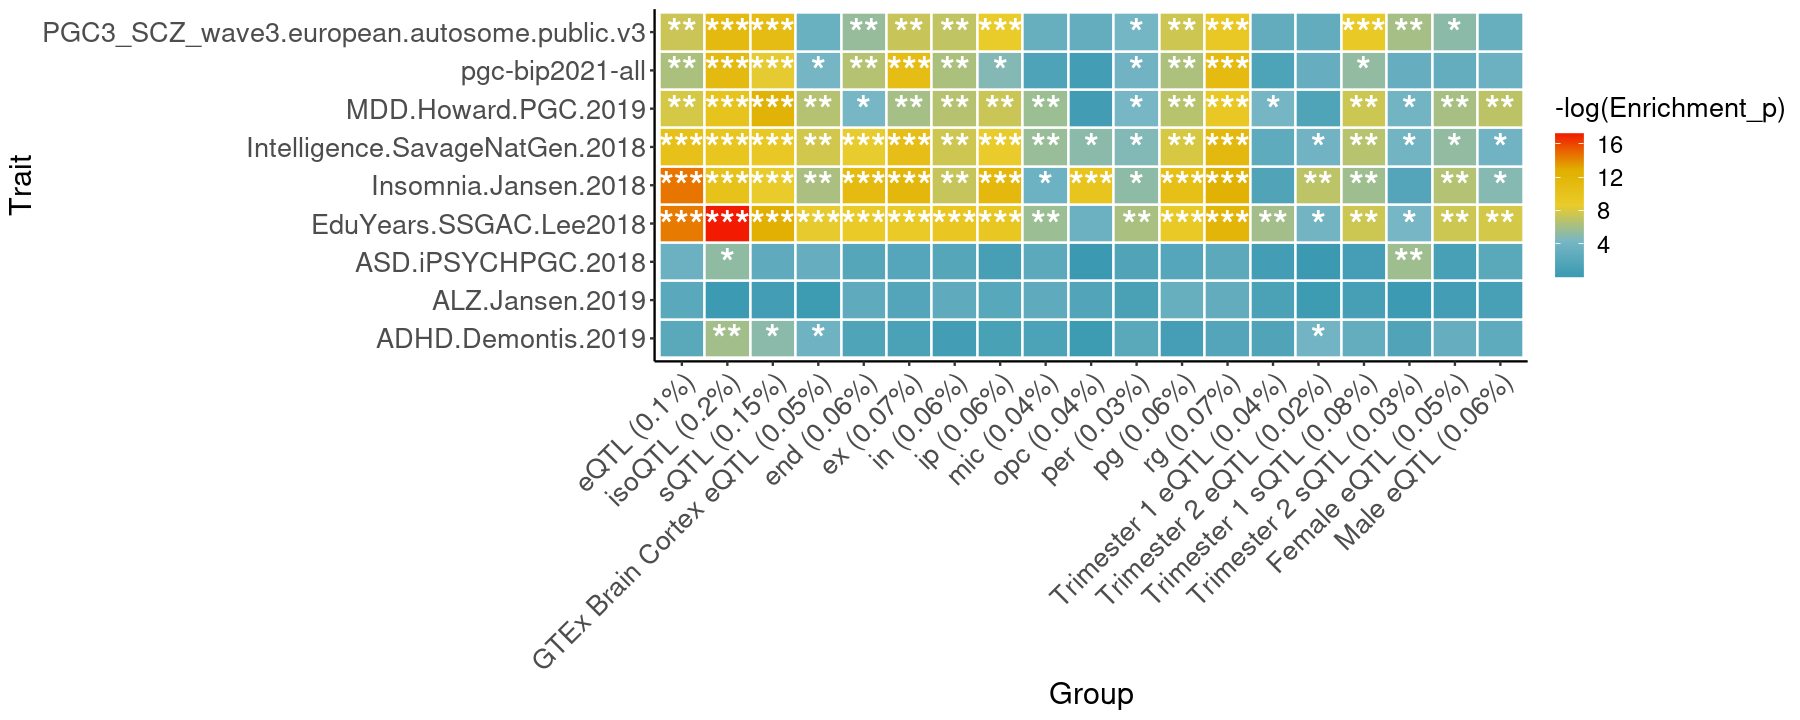

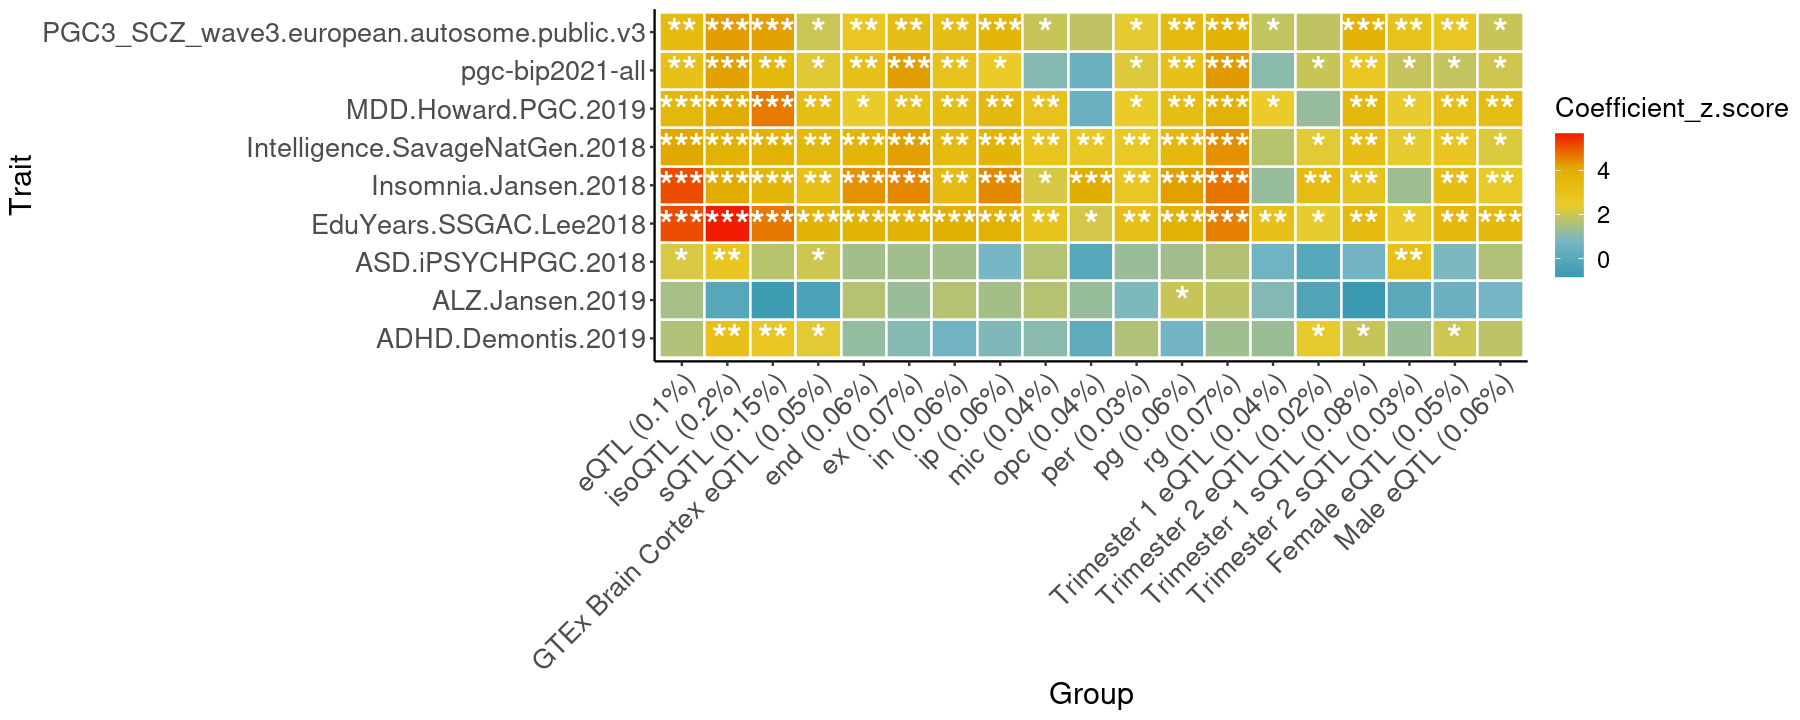

In [46]:
options(repr.plot.width = 15, repr.plot.height = 6)

pal <- wes_palette("Zissou1", 100, type = "continuous")

p <- ggplot(df, aes(x = Group, y = Trait, fill = Coefficient)) +
    geom_tile(colour = "white", size = 0.5) +
#     facet_wrap(~set, scales='free_x') +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "right") +
#     scale_fill_gradient(low = "white", high = "blue")
#     scale_fill_gradient2(low = "grey", mid = "white", high = "blue", midpoint = 0)
          scale_fill_gradientn(colours = pal) +
#     geom_vline(xintercept = "sQTL (0.15%)", color = "white", linetype = "dashed", size = 2)
    geom_text(aes(label = tau.signif), color = "white", size = 8, fontface = "bold")
p

p0 <- ggplot(df, aes(x = Group, y = Trait, fill = -log(tau_pval))) +
    geom_tile(colour = "white", size = 0.5) +
#     facet_wrap(~set, scales='free_x') +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "right") +
#     scale_fill_gradient(low = "white", high = "blue")
#     scale_fill_gradient2(low = "grey", mid = "white", high = "blue", midpoint = 0)
          scale_fill_gradientn(colours = pal) +
#     geom_vline(xintercept = "sQTL (0.15%)", color = "white", linetype = "dashed", size = 2)
    geom_text(aes(label = tau.signif), color = "white", size = 8, fontface = "bold")
p0

p1 <- ggplot(df, aes(x = Group, y = Trait, fill = Enrichment)) +
    geom_tile(colour = "white", size = 0.5) +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "right") +
#     scale_fill_gradient(low = "white", high = "blue") +
    scale_fill_gradientn(colours = pal) +
    geom_text(aes(label = en.signif), color = "white", size = 8, fontface = "bold")
p1

p2 <- ggplot(df, aes(x = Group, y = Trait, fill = -log(Enrichment_p))) +
    geom_tile(colour = "white", size = 0.5) +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "right") +
#     scale_fill_gradient(low = "white", high = "blue") +
    scale_fill_gradientn(colours = pal) +
    geom_text(aes(label = en.signif), color = "white", size = 8, fontface = "bold")
p2

p3 <- ggplot(df, aes(x = Group, y = Trait, fill = Coefficient_z.score)) +
    geom_tile(colour = "white", size = 0.5) +
#     facet_wrap(~set, scales='free_x') +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "right") +
#     scale_fill_gradient(low = "white", high = "blue")
#     scale_fill_gradient2(low = "grey", mid = "white", high = "blue", midpoint = 0)
          scale_fill_gradientn(colours = pal) +
#     geom_vline(xintercept = "sQTL (0.15%)", color = "white", linetype = "dashed", size = 2)
    geom_text(aes(label = tau.signif), color = "white", size = 8, fontface = "bold")
p3

In [47]:
ggsave("../figures/ldsc_tau.pdf", p, width = 15, height = 6)
ggsave("../figures/ldsc_tau_p.pdf", p0, width = 15, height = 6)
ggsave("../figures/ldsc_enrich.pdf", p1, width = 15, height = 6)
ggsave("../figures/ldsc_enrich_p.pdf", p2, width = 15, height = 6)
ggsave("../figures/ldsc_tau_zscore.pdf", p3, width = 15, height = 6)